In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn_pandas import DataFrameMapper

import torch
from torch import Tensor
import torchtuples as tt
import argparse
from pycox.datasets import metabric, gbsg, support, flchain, nwtco
from pycox.models import CoxPH
from pycox.evaluation import EvalSurv
import warnings
from lifelines import KaplanMeierFitter
from lifelines import NelsonAalenFitter
from lifelines.utils import concordance_index
import numpy as np
import pandas as pd
import warnings
import math
from pycox.preprocessing.feature_transforms import OrderedCategoricalLong
from torchtuples.practical import MixedInputMLP
from easydict import EasyDict as edict

In [2]:
## DSAFT - rank loss function
def dsaft_rank_loss(theta, durations, events, weight = None, alpha = 0.0, beta = 0.0, gamma = 0.0, delta = 0.0):
    '''
    theta: prediction output from DNN layers
    durations: log-scaled observed time (log(Y))
    events: right-censoring-indicator (delta)
    '''
    n = durations.shape[0]
    
    # compute residual e_i
    e = theta.sub(durations.view(-1,1).add(1e-32).log()).neg()
    
    # evaluate loss function based on formula,
    # mul(1 / e_vector.shape[0] ** 2) : scaling constant
    
    loss = e.sub(e.view(-1)).mul(e.sub(e.view(-1))<=0).abs().mul(events.view(-1,1)).sum().mul(1 / n ** 2)
    
    # penalty_1 = e.abs().sub(e).div(2).pow(2).mul(events.sub(1).abs()).sum().div(n).mul(alpha)
    # penalty_2 = e.pow(2).mul(events).sum().div(n).mul(beta)
    
#    penalty_1 = e.abs().add(e).div(2).pow(2).sum().div(n).mul(alpha)
    penalty_2 = e.pow(2).sum().div(n).mul(beta)
    penalty_3 = theta.pow(2).sum().div(n).mul(gamma)
    
#    grid_size = 1000
    
#    if n < 1000:
#        grid_size = n
        
#    grid = np.round(np.linspace(0, grid_size - 1, 1000))
#    t = theta[grid]
#    y = durations[grid]
#    d = events[grid]
    
#    first = t.neg().exp().neg().exp().pow(2).view(-1).mul(d.mul(y.view(-1,1).sub(y) >= 0)).sum(1)
#    second = t.neg().exp().neg().exp().sub(1).neg().pow(2).view(-1).mul(y.view(-1,1).sub(y) < 0).sum(1)
#    penalty_4 = first.add(second).sum().div(grid_size).mul(delta)
    
    return loss + penalty_2 + penalty_3


## Classes below
class DSAFTRankLoss(torch.nn.Module):
    def __init__(self, weight = None, alpha = 0.0, beta = 0.0, gamma = 0.0, delta = 0.0):
        super(DSAFTRankLoss, self).__init__()
        self.weight = weight
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        self.delta = delta
    def forward(self, log_h: Tensor, durations: Tensor, events: Tensor) -> Tensor:
        return dsaft_rank_loss(log_h, durations, events, weight = self.weight,
                               alpha = self.alpha, beta = self.beta,
                               gamma = self.gamma, delta = self.delta)

In [3]:
def get_score(n, t, y_test, delta_test, naf_base, kmf_cens, cens_test, exp_predict_neg_test, surv_residual, cens_residual, model):
    exp_residual_t = np.nan_to_num(np.exp(np.repeat(np.log(t),n) - model.predict(x_test).reshape(-1)))
    
    if surv_residual == True:
        H_base = naf_base.cumulative_hazard_at_times(exp_residual_t).values
    elif surv_residual == False:
        H_base = naf_base.cumulative_hazard_at_times(t).values        
    
    if cens_residual == True:
        cens_t = kmf_cens.survival_function_at_times(exp_residual_t).values
    elif cens_residual == False:
        cens_t = np.repeat(kmf_cens.survival_function_at_times(t).values, n)

    surv_cond = np.exp(-(H_base * exp_predict_neg_test)) - 1e-16
    
    indicator_first = (y_test <= t) * delta_test
    indicator_second = (y_test > t) * 1

    first_bs = np.power(surv_cond, 2) * indicator_first / cens_test
    second_bs = np.power(1 - surv_cond, 2) * indicator_second / cens_t
    bs = (first_bs + second_bs).sum() / n
    
    first_nbll = np.log(1 - surv_cond + 1e-16) * indicator_first / cens_test
    second_nbll = np.log(surv_cond + 1e-16) * indicator_second / cens_t
    nbll = (first_nbll + second_nbll).sum() / n
    
    return (bs, nbll)

def get_scores(model, y_test, delta_test, time_grid, surv_residual = False, cens_residual = False):
    n = y_test.shape[0]
    x_train, target = model.training_data
    y_train, delta_train = target

    # compute residual from training data
    exp_residual_train = np.nan_to_num(np.exp(np.log(y_train) - model.predict(x_train).reshape(-1)))
    exp_residual_test = np.nan_to_num(np.exp(np.log(y_test) - model.predict(x_test).reshape(-1)))

    # compute exp(-theta) from test data to evaluate accelerating component
    exp_predict_neg_test = np.nan_to_num(np.exp(-model.predict(x_test)).reshape(-1))

    naf_base = NelsonAalenFitter().fit(y_train, event_observed = delta_train)
    kmf_cens = KaplanMeierFitter().fit(y_train, event_observed = 1 - delta_train)
    
    if cens_residual == True:
        cens_test = kmf_cens.survival_function_at_times(exp_residual_test)
    elif cens_residual == False:
        cens_test = kmf_cens.survival_function_at_times(y_test)

    bss = []
    nblls = []
    for t in time_grid:
        bs, nbll = get_score(n, t, y_test, delta_test, naf_base, kmf_cens, cens_test, exp_predict_neg_test, surv_residual, cens_residual, model)
        bss.append(bs)
        nblls.append(-nbll)

    return (np.array(bss), np.array(nblls))

In [4]:
args = edict(seed = 1234,
             device = 0,
             dataset = 'kkbox',
             loss = 'rank',
             optimizer = 'AdamWR',
             alpha = 0.0,
             beta = 0.0,
             num_nodes = 512,
             num_layers = 6,
             batch_size = 1024,
             epochs = 512,
             lr = 1e-5,
             weight_decay = 0.0,
             dropout = 0.0,
             use_BN = True,
             use_output_bias = True)

In [5]:
device = f'cuda:{args.device}' if torch.cuda.is_available() else 'cpu'
device = torch.device(device)

np.random.seed(args.seed)
torch.manual_seed(args.seed)

In [6]:
# Data preparation ==============================================================
if args.dataset=='metabric':
    df_train = metabric.read_df()
    cols_standardize = ['x0', 'x1', 'x2', 'x3', 'x8']
    cols_leave = ['x4', 'x5', 'x6', 'x7']
    cols_categorical = []
    num_embeddings = [len(pd.concat([df_train,df_val,df_test])[cat].unique()) for cat in cols_categorical]
    embedding_dims = [math.ceil(n_emb/2) for n_emb in num_embeddings]
elif args.dataset=='gbsg':
    df_train = gbsg.read_df()
    cols_standardize = ["x3", "x4", "x5", "x6"]
    cols_leave = ["x0", "x2"]
    cols_categorical = ["x1"]
    num_embeddings = [len(pd.concat([df_train,df_val,df_test])[cat].unique()) for cat in cols_categorical]
    embedding_dims = [math.ceil(n_emb/2) for n_emb in num_embeddings]
elif args.dataset=='support':
    df_train = support.read_df()
    cols_standardize =  ["x0", "x3", "x7", "x8", "x9", "x10", "x11", "x12", "x13"]
    cols_leave = ["x1", "x4", "x5"]
    cols_categorical =  ["x2", "x6"]
    num_embeddings = [len(pd.concat([df_train,df_val,df_test])[cat].unique()) for cat in cols_categorical]
    embedding_dims = [math.ceil(n_emb/2) for n_emb in num_embeddings]
elif args.dataset=='flchain':
    df_train = flchain.read_df()
    df_train.columns =  ["x0", "x1", "x2", "x3", "x4", "x5", "x6", "x7", "duration", "event"]
    cols_standardize =  ["x0", "x3", "x4", "x6"]
    cols_leave = ["x1", "x7"]
    cols_categorical = ["x2", "x5"]
    num_embeddings = [len(pd.concat([df_train,df_val,df_test])[cat].unique()) for cat in cols_categorical]
    embedding_dims = [math.ceil(n_emb/2) for n_emb in num_embeddings]
elif args.dataset=='kkbox':
    from kkbox import _DatasetKKBoxChurn
    kkbox_v1 = _DatasetKKBoxChurn()
    try:
        df_train = kkbox_v1.read_df(subset='train')
        df_val = kkbox_v1.read_df(subset='val')
        df_test = kkbox_v1.read_df(subset='test')
    except:
        kkbox_v1.download_kkbox()
        df_train = kkbox_v1.read_df(subset='train')
        df_val = kkbox_v1.read_df(subset='val')
        df_test = kkbox_v1.read_df(subset='test')
    cols_standardize = ['n_prev_churns', 'log_days_between_subs', 'log_days_since_reg_init' ,'age_at_start', 'log_payment_plan_days', 'log_plan_list_price', 'log_actual_amount_paid']
    cols_leave =['is_auto_renew', 'is_cancel', 'strange_age', 'nan_days_since_reg_init', 'no_prev_churns']
    cols_categorical = ['city', 'gender', 'registered_via']

elif args.dataset=='kkbox_v2':
    from kkbox import _DatasetKKBoxAdmin
    kkbox_v2 = _DatasetKKBoxAdmin()
    try:
        df_train = kkbox_v2.read_df()
    except:
        kkbox_v2.download_kkbox()
        df_train = kkbox_v2.read_df()
    cols_standardize = ['n_prev_churns', 'log_days_between_subs', 'log_days_since_reg_init' ,'age_at_start', 'log_payment_plan_days', 'log_plan_list_price', 'log_actual_amount_paid']
    cols_leave =['is_auto_renew', 'is_cancel', 'strange_age', 'nan_days_since_reg_init', 'no_prev_churns']
    cols_categorical = ['city', 'gender', 'registered_via','payment_method_id']

if args.dataset=='kkbox_v2':
    df_test = df_train.sample(frac=0.25)
    df_train = df_train.drop(df_test.index)
    df_val = df_train.sample(frac=0.1)
    df_train = df_train.drop(df_val.index)
elif not (args.dataset == 'kkobx'):
    df_test = df_train.sample(frac=0.2)
    df_train = df_train.drop(df_test.index)
    df_val = df_train.sample(frac=0.2)
    df_train = df_train.drop(df_val.index)


standardize = [([col], StandardScaler()) for col in cols_standardize]
leave = [(col, None) for col in cols_leave]
categorical = [(col, OrderedCategoricalLong()) for col in cols_categorical]

x_mapper_float = DataFrameMapper(standardize + leave)
x_mapper_long = DataFrameMapper(categorical)

x_fit_transform = lambda df: tt.tuplefy(x_mapper_float.fit_transform(df).astype(np.float32), x_mapper_long.fit_transform(df))
x_transform = lambda df: tt.tuplefy(x_mapper_float.transform(df).astype(np.float32), x_mapper_long.transform(df))
x_train = x_fit_transform(df_train)
x_val = x_transform(df_val)
x_test = x_transform(df_test)
num_embeddings = x_train[1].max(0) + 1
embedding_dims = num_embeddings // 2

get_target = lambda df: (df['duration'].values, df['event'].values)
y_train = get_target(df_train)
y_val = get_target(df_val)
durations_test, events_test = get_target(df_test)
val = x_val, y_val

def replace_zero(duration):
    return np.where(duration <= 0.0, duration + np.sort(np.unique(duration))[1], duration)

# log-transformed time-to-event variables with replacement of zero-valued instances
train_log_replace = np.log(replace_zero(y_train[0])).reshape(-1, 1)
val_log_replace = np.log(replace_zero(y_val[0])).reshape(-1, 1)
test_log_replace = np.log(replace_zero(durations_test)).reshape(-1, 1)

# standardizer trained with training dataset
scaler_train = StandardScaler().fit(train_log_replace)

# scaled time-to-event datasets for consistent training
y_train_transformed = (np.exp(scaler_train.transform(train_log_replace).reshape(-1)), y_train[1])
y_val_transformed = (np.exp(scaler_train.transform(val_log_replace).reshape(-1)), y_val[1])
val_transformed = x_val, y_val_transformed 
durations_test_transformed = np.exp(scaler_train.transform(test_log_replace).reshape(-1))

In [7]:
# Model preparation =============================================================    
in_features = x_train[0].shape[1]
num_nodes = [args.num_nodes]* args.num_layers
out_features = 1
batch_norm = args.use_BN
dropout = args.dropout
output_bias = args.use_output_bias
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# net = tt.practical.MLPVanilla(in_features, num_nodes, out_features, batch_norm,
#                             dropout, output_bias=output_bias)
net = MixedInputMLP(in_features, num_embeddings, embedding_dims, num_nodes, out_features, batch_norm, dropout, output_bias=output_bias)
# net = Transformer(in_features, num_embeddings, num_nodes, out_features, batch_norm, dropout, output_bias=output_bias)
net = net.to(device)

if args.optimizer == 'AdamWR':
    model = CoxPH(net, optimizer=tt.optim.AdamWR(lr=args.lr, decoupled_weight_decay=args.weight_decay),device=device)
elif args.optimizer=='AdamW':
    model = CoxPH(net, optimizer=tt.optim.AdamW(lr=args.lr, decoupled_weight_decay=args.weight_decay),device=device)
elif args.optimizer =='Adam':
    model = CoxPH(net, optimizer=tt.optim.Adam(lr=args.lr, weight_decay=args.weight_decay),device=device)



# Loss configuration ============================================================

patience=10
if args.loss =='rank':
    model.loss = DSAFTRankLoss(alpha=args.alpha, beta=args.beta)
elif args.loss == 'mae':
    model.loss = DSAFTMAELoss()
elif args.loss == 'rmse':
    model.loss = DSAFTRMSELoss()
elif args.loss =='kspl':
    model.loss = DSAFTNKSPLLoss(args.an, args.sigma)
elif args.loss =='kspl_new':
    model.loss = DSAFTNKSPLLossNew(args.an, args.sigma)

In [8]:
batch_size = args.batch_size
model.optimizer.set_lr(args.lr)

epochs = args.epochs
callbacks = [tt.callbacks.EarlyStopping(patience=patience,checkpoint_model = False, load_best = False)]
verbose = True

In [9]:
log = model.fit(x_train, y_train_transformed, batch_size, epochs, callbacks, verbose, val_data = val_transformed, val_batch_size = batch_size)

0:	[47s / 47s],		train_loss: 0.2133,	val_loss: 0.2009
1:	[44s / 1m:31s],		train_loss: 0.2009,	val_loss: 0.1967
2:	[44s / 2m:16s],		train_loss: 0.1981,	val_loss: 0.1960
3:	[43s / 3m:0s],		train_loss: 0.1977,	val_loss: 0.1952
4:	[43s / 3m:44s],		train_loss: 0.1963,	val_loss: 0.1945
5:	[43s / 4m:27s],		train_loss: 0.1954,	val_loss: 0.1941
6:	[43s / 5m:11s],		train_loss: 0.1950,	val_loss: 0.1940
7:	[44s / 5m:56s],		train_loss: 0.1955,	val_loss: 0.1941
8:	[44s / 6m:41s],		train_loss: 0.1949,	val_loss: 0.1939
9:	[45s / 7m:26s],		train_loss: 0.1945,	val_loss: 0.1937
10:	[45s / 8m:12s],		train_loss: 0.1940,	val_loss: 0.1934
11:	[47s / 8m:59s],		train_loss: 0.1936,	val_loss: 0.1932
12:	[46s / 9m:45s],		train_loss: 0.1934,	val_loss: 0.1930
13:	[44s / 10m:30s],		train_loss: 0.1932,	val_loss: 0.1929
14:	[48s / 11m:18s],		train_loss: 0.1931,	val_loss: 0.1929
15:	[44s / 12m:3s],		train_loss: 0.1938,	val_loss: 0.1934
16:	[44s / 12m:47s],		train_loss: 0.1936,	val_loss: 0.1932
17:	[43s / 13m:31s],		tra

In [10]:
# get Ctd
ctd = concordance_index(event_times = durations_test_transformed,
                        predicted_scores = model.predict(x_test).reshape(-1),
                        event_observed = events_test)

In [11]:
# set time grid for numerical integration to get IBS and IBLL
time_grid = np.linspace(durations_test.min(), durations_test.max(), 100)
# transform time grid into DSAFT scale for fair comparison
time_grid = np.exp(scaler_train.transform(np.log(time_grid.reshape(-1, 1)))).reshape(-1)
# grid interval for numerical integration
ds = np.array(time_grid - np.array([0.0] + time_grid[:-1].tolist()))
# get BS's and NBLL's for given timepoints
bs, nbll = get_scores(model, durations_test_transformed, events_test, time_grid, surv_residual = True, cens_residual = True)
# get IBS
ibs = sum(bs * ds) / (time_grid.max() - time_grid.min())
ibll = sum(nbll * ds) / (time_grid.max() - time_grid.min())

C:\Users\lhj63\Anaconda3\lib\site-packages\lifelines\fitters\nelson_aalen_fitter.py:168: RuntimeWarning: divide by zero encountered in true_divide
  cum_ = np.cumsum(1.0 / np.arange(1, np.max(population) + 1) ** 2)
C:\Users\lhj63\Anaconda3\lib\site-packages\lifelines\fitters\nelson_aalen_fitter.py:170: RuntimeWarning: invalid value encountered in subtract
  cum_[population - 1] - np.where(population - deaths - 1 >= 0, cum_[population - deaths - 1], 0),
C:\Users\lhj63\Anaconda3\lib\site-packages\lifelines\fitters\nelson_aalen_fitter.py:163: RuntimeWarning: invalid value encountered in sqrt
  df[ci_labels[0]] = cum_hazard_ * np.exp(-z * np.sqrt(cumulative_sq_) / np.where(cum_hazard_ == 0, 1, cum_hazard_))
C:\Users\lhj63\Anaconda3\lib\site-packages\lifelines\fitters\nelson_aalen_fitter.py:164: RuntimeWarning: invalid value encountered in sqrt
  df[ci_labels[1]] = cum_hazard_ * np.exp(z * np.sqrt(cumulative_sq_) / np.where(cum_hazard_ == 0, 1, cum_hazard_))


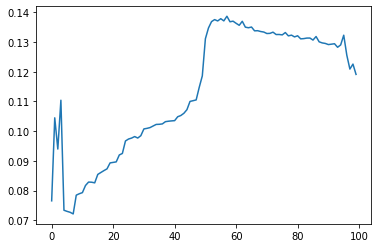

In [12]:
plt.plot(bs)

In [13]:
print(ctd)
print(ibs)
print(ibll)

0.8650245063384407
0.1083231927591748
0.3214714492111303
